In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import pairwise_distances
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import kstest
import os
from collections import Counter

z_thresh = 4
filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/megadicts"

In [3]:
def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

In [2]:
data_pre =  "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/ID474/psilo/TSeries-10132023-1324-142/suite2p/plane0/cells.pkl"

with open(data_pre,'rb') as f:
    pre_data = pickle.load(f)

In [3]:
nfreq = list(pre_data[1]['traces'].keys())
nInt = list(pre_data[1]['traces'][nfreq[0]].keys())
ntrial = list(pre_data[1]['traces'][nfreq[0]][nInt[0]].keys())
print(nfreq, nInt, ntrial)


[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922] [35, 50, 65, 80] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [5]:
pre_active = {key: pre_data[key] for key in pre_data if pre_data[key]['active'] == True}

print(pre_active.keys())


dict_keys([6, 10, 11, 13, 14, 16, 19, 21, 24, 25, 30, 35, 37, 41, 44, 45, 49, 50, 51, 53, 55, 56, 57, 66, 70, 72, 75, 77, 78, 79, 80, 81, 82, 83, 88, 89, 91, 101, 102, 104, 106, 107, 108, 110, 111, 112, 114, 115, 119, 120, 122, 123, 124, 126, 134, 136, 140, 141, 142, 147, 150, 151, 152, 153, 154, 155, 160, 161, 167, 169, 170, 172, 173, 175, 176, 177, 178, 182, 183, 184, 185, 192, 195, 197, 202, 203, 204, 205, 206, 207, 208, 209, 212, 216, 217, 220, 223, 226, 231, 233, 239, 243, 245, 252, 258, 266, 278, 284, 286, 288, 291, 293, 297, 299, 301, 306, 309, 310, 311, 323, 327, 331, 333, 336, 346, 349, 353, 354, 360, 368, 370, 381, 382, 385, 390, 395, 397, 431, 433, 439, 442, 443, 445, 448, 449, 454, 456, 460, 462, 463, 479, 480, 483, 495, 496, 507, 512, 519, 526, 531, 535, 537, 551, 555, 560, 567, 571, 579, 581, 584, 589, 614, 615, 618, 625, 632, 634, 639, 646, 664, 668, 672, 690, 698, 701, 711, 724, 732, 738, 768, 772, 801, 815, 818, 823, 852, 869, 880, 894, 915, 919, 926, 934, 1018, 1047, 

In [6]:
matrix = np.array([[[[pre_active[n]['deconvolved_traces'][i][j][k] for n in pre_active.keys()] for k in ntrial] for j in nInt] for i in nfreq])

print(matrix.shape)

(12, 4, 10, 209, 15)


In [30]:
# Compute a single baseline for each cell (first 5 trial frames) and baseline correct all trials.  Don't store the baseline values. 

matrix_corrected = np.zeros((12,4,10,209,10))

for i in range(matrix.shape[3]):
    baseline = np.mean(matrix[:, :, :, i, :5])
    corrected_cell = matrix[:,:,:,i,5:] - baseline
    matrix_corrected[:,:,:,i,:] = corrected_cell

peak_matrix = matrix_corrected.mean(axis=4)
print(peak_matrix.shape)

(12, 4, 10, 209)


In [11]:
thresholded_peaks = np.where(peak_matrix < 4, 0, peak_matrix)

print(thresholded_peaks.shape)


(12, 4, 10, 209)


In [99]:
from scipy.stats import pearsonr

correlation_matrix_all_cells = []
p_value_matrix_all_cells = []


correlation_matrix = np.zeros((10, 10))
p_value_matrix = np.zeros((10, 10))

cell = thresholded_peaks[:,:,:,1]

for i in range(thresholded_peaks.shape[2]):
    for j in range(thresholded_peaks.shape[2]):
        if i == j:
            correlation_matrix[i, j] = 1.0  # Correlation with itself is 1.0
            p_value_matrix[i, j] = np.nan  # P-value is not defined for self-correlation
        else:
            correlation_matrix[i, j], p_value_matrix[i, j] = pearsonr(cell[:,:,i].flatten(), cell[:,:,j].flatten())

# Display correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

# Display p-value matrix
print("\nP-value matrix:")
print(p_value_matrix)


Correlation matrix:
[[ 1.          0.07371042 -0.16699776  0.05557788  0.5367125  -0.02234253
   0.15788351 -0.02556739  0.35703364  0.1929351 ]
 [ 0.07371042  1.         -0.15300048 -0.03350268  0.02503658  0.17074016
  -0.07654532  0.06973979  0.39644412  0.12797024]
 [-0.16699776 -0.15300048  1.          0.0437465   0.03948358 -0.13058412
   0.03474324  0.22234048 -0.07946525 -0.00602885]
 [ 0.05557788 -0.03350268  0.0437465   1.          0.42211018  0.24488113
   0.18770702 -0.0156647   0.01043503  0.70321886]
 [ 0.5367125   0.02503658  0.03948358  0.42211018  1.          0.28366587
   0.18744441  0.01814375  0.08623989  0.47053817]
 [-0.02234253  0.17074016 -0.13058412  0.24488113  0.28366587  1.
   0.27050603 -0.0843195  -0.08481128  0.2612151 ]
 [ 0.15788351 -0.07654532  0.03474324  0.18770702  0.18744441  0.27050603
   1.         -0.03694116  0.00496895  0.32626445]
 [-0.02556739  0.06973979  0.22234048 -0.0156647   0.01814375 -0.0843195
  -0.03694116  1.         -0.10472215 -0

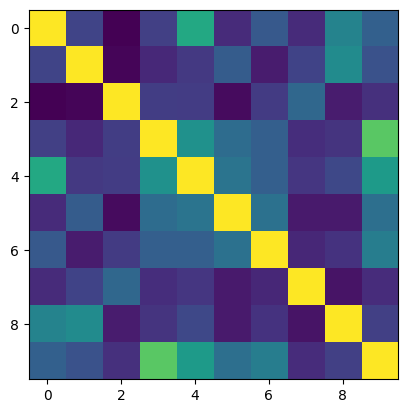

In [101]:
plt.imshow(correlation_matrix)

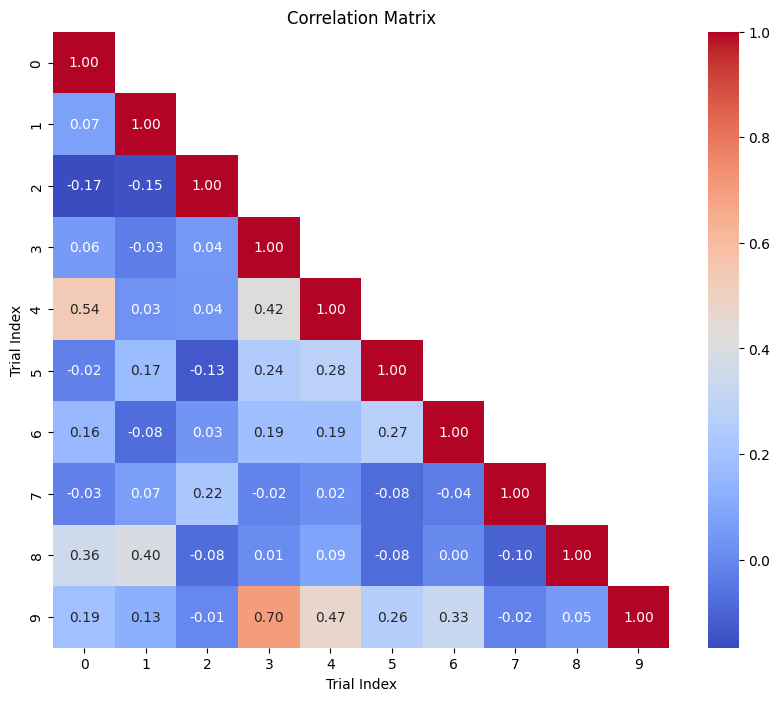

In [102]:
# Mask upper triangle and diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.xlabel('Trial Index')
plt.ylabel('Trial Index')
plt.show()

In [4]:
# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

In [5]:
nfreq = list(saline_pre['saline_1_186'][1]['deconvolved_traces'].keys())
nInt = list(saline_pre['saline_1_186'][1]['deconvolved_traces'][nfreq[0]].keys())
ntrial = list(saline_pre['saline_1_186'][1]['deconvolved_traces'][nfreq[0]][nInt[0]].keys())
print(nfreq, nInt, ntrial)

[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922] [35, 50, 65, 80] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [6]:
def get_quality_index_all_cells(dict):

    QI_all = []

    sub_dict_keys = dict.keys()

    for sub_dict in sub_dict_keys:

      
      
        active = {cell: dict[sub_dict][cell] for cell in dict[sub_dict] if dict[sub_dict][cell]['active'] == True}
        
        
        matrix = np.array([[[[active[n]['deconvolved_traces'][i][j][k] for n in active.keys()] for k in ntrial] for j in nInt] for i in nfreq])
        
        matrix_corrected = np.zeros((12,4,10,matrix.shape[3],10))

        for i in range(matrix.shape[3]):
            baseline = np.mean(matrix[:, :, :, i, :5])
            corrected_cell = matrix[:,:,:,i,5:] - baseline
            matrix_corrected[:,:,:,i,:] = corrected_cell

        peak_matrix = matrix_corrected.max(axis=4)

        peak_matrix_concat = peak_matrix.reshape(-1, *peak_matrix.shape[-2:])
    
        for i in range(peak_matrix_concat.shape[2]):
            x = peak_matrix_concat[:,:,i]
            
            # Formula for Quality Index on a single cell
            QI = np.var(x.mean(axis=1))/np.mean(x.var(axis=0))

            QI_all.append(QI)

    return QI_all

In [7]:
QI_all_cells_saline_pre = get_quality_index_all_cells(saline_pre)
QI_all_cells_saline_post = get_quality_index_all_cells(saline_post)

QI_all_cells_psilo_pre = get_quality_index_all_cells(psilo_pre)
QI_all_cells_psilo_post = get_quality_index_all_cells(psilo_post)

In [9]:
# Perform KS test between two samples
ks_statistic, p_value = ss.kstest(QI_all_cells_psilo_pre, QI_all_cells_psilo_post)

# Print test results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.03793542120266351
P-value: 0.3395546249006336


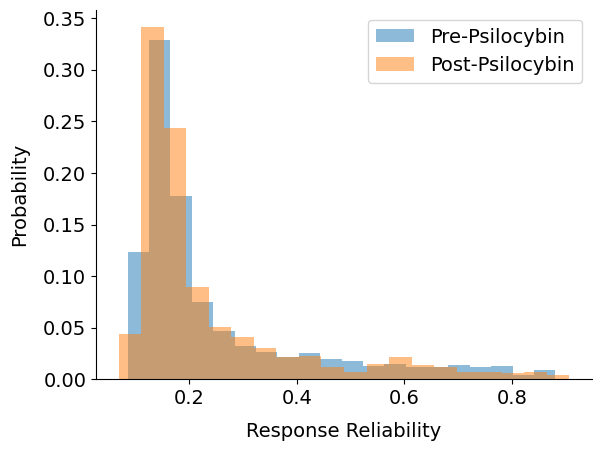

In [8]:
# plotting histograms 
data1 = QI_all_cells_psilo_pre
data2 = QI_all_cells_psilo_post
label1 = 'Pre-Psilocybin'
label2 = 'Post-Psilocybin'

plt.hist(data1, weights=np.zeros_like(data1) + 1. / len(data1),bins=20,  
         label=label1,alpha=0.5) 
  
plt.hist(data2, weights=np.zeros_like(data2) + 1. / len(data2),bins=20,  
         label=label2,alpha=0.5) 
  
plt.legend(loc='upper right',fontsize=14) 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('',pad=10) 
plt.xlabel("Response Reliability",fontsize=14,labelpad=10)
plt.ylabel("Probability",fontsize=14,labelpad=10)
plt.show()

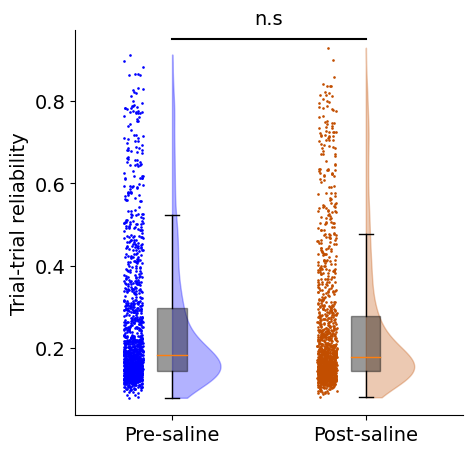

In [23]:
data_x = [QI_all_cells_saline_pre, QI_all_cells_saline_post]

fig, ax = plt.subplots(figsize=(5, 5))

# Create a list of colors for the boxplots based on the number of features you have
boxplots_colors = ['black', 'black']

# Boxplot data
bp = ax.boxplot(data_x, patch_artist=True,showfliers=False)

# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], boxplots_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Create a list of colors for the violin plots based on the number of features you have
violin_colors = ['b', '#c24e00']

# Violinplot data
vp = ax.violinplot(data_x, points=500, showmeans=False, showextrema=False, showmedians=False)

for idx, b in enumerate(vp['bodies']):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 1])
    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], idx + 1, idx + 2)
    # Change to the desired color
    b.set_color(violin_colors[idx])

# Create a list of colors for the scatter plots based on the number of features you have
scatter_colors = ['b', '#c24e00']

# Scatterplot data
for idx, features in enumerate(data_x):
    # Add jitter effect so the features do not overlap on the x-axis
    x = np.full(len(features), idx + .8)
    idxs = np.arange(len(x))
    out = x.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
    x = out
    plt.scatter(x, features, s=.8, c=scatter_colors[idx])

plt.xticks(np.arange(1, 3, 1), ['Pre-saline', 'Post-saline'],fontsize=14)  # Set text labels.
# plt.ylim(bottom=min(min(QI_all_cells_saline_pre), min(QI_all_cells_saline_post)), top=1.1)  # Limit y-axis to values below 10
plt.ylabel('Trial-trial reliability',fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(xmin=0.25, xmax=0.75, y=0.95, color='black', linestyle='-')
plt.text(1.5, 1, 'n.s', horizontalalignment='center', verticalalignment='center',fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

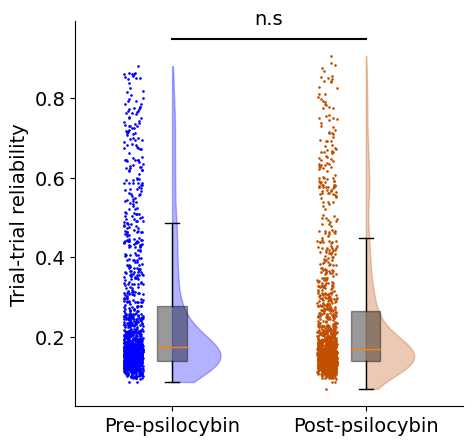

In [22]:
data_x = [QI_all_cells_psilo_pre, QI_all_cells_psilo_post]

fig, ax = plt.subplots(figsize=(5, 5))

# Create a list of colors for the boxplots based on the number of features you have
boxplots_colors = ['black', 'black']

# Boxplot data
bp = ax.boxplot(data_x, patch_artist=True,showfliers=False)

# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], boxplots_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Create a list of colors for the violin plots based on the number of features you have
violin_colors = ['b', '#c24e00']

# Violinplot data
vp = ax.violinplot(data_x, points=500, showmeans=False, showextrema=False, showmedians=False)

for idx, b in enumerate(vp['bodies']):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 1])
    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], idx + 1, idx + 2)
    # Change to the desired color
    b.set_color(violin_colors[idx])

# Create a list of colors for the scatter plots based on the number of features you have
scatter_colors = ['b', '#c24e00']

# Scatterplot data
for idx, features in enumerate(data_x):
    # Add jitter effect so the features do not overlap on the x-axis
    x = np.full(len(features), idx + .8)
    idxs = np.arange(len(x))
    out = x.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
    x = out
    plt.scatter(x, features, s=.8, c=scatter_colors[idx])

plt.xticks(np.arange(1, 3, 1), ['Pre-psilocybin', 'Post-psilocybin'],fontsize=14)  # Set text labels.
# plt.ylim(bottom=min(min(QI_all_cells_saline_pre), min(QI_all_cells_saline_post)), top=1.1)  # Limit y-axis to values below 10
plt.ylabel('Trial-trial reliability',fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(xmin=0.25, xmax=0.75, y=0.95, color='black', linestyle='-')
plt.text(1.5, 1, 'n.s', horizontalalignment='center', verticalalignment='center',fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Text(0, 0.5, 'Probability')

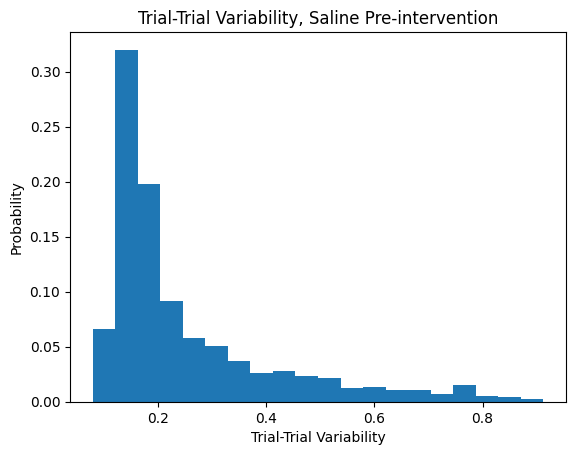

In [8]:
plt.hist(QI_all_cells_saline_pre, weights=np.zeros_like(QI_all_cells_saline_pre) + 1. / len(QI_all_cells_saline_pre),bins=20)

plt.title("Trial-Trial Variability, Saline Pre-intervention")
plt.xlabel("Trial-Trial Variability")
plt.ylabel("Probability")

Text(0, 0.5, 'Probability')

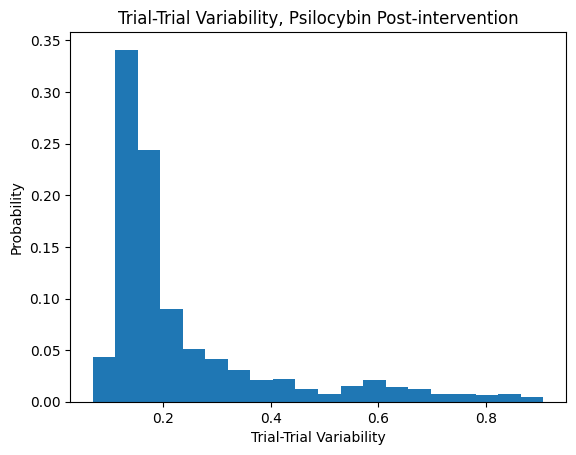

In [10]:
plt.hist(QI_all_cells_psilo_post, weights=np.zeros_like(QI_all_cells_psilo_post) + 1. / len(QI_all_cells_psilo_post),bins=20)

plt.title("Trial-Trial Variability, Psilocybin Post-intervention")
plt.xlabel("Trial-Trial Variability")
plt.ylabel("Probability")

In [9]:
# Perform KS test between two samples
ks_statistic, p_value = ss.kstest(QI_all_cells_psilo_pre, QI_all_cells_psilo_post)

# Print test results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.03793542120266351
P-value: 0.3395546249006336


In [19]:
# # Get the indices that would sort the array in descending order
# sorted_indices = np.argsort(QI_all)[::-1]

# # Get the top 10 indices
# top_10_indices = sorted_indices[:10]

# # Get the top 10 indices
# bot_10_indices = sorted_indices[-10:]

# print(top_10_indices)
# print(bot_10_indices)

In [10]:
# Create an array of all the matched cells that are sound-responsive in both recordings.  Each row is a matched cell pair. 
# INPUTS:  pre- and post- megadicts for a given drug condition. 
#          The specific recording to get matched cells for in the sub-dictionaries of pre- and post.
#          Code is written to be used with the matched cells bandwidth functions. 
# OUTPUTS: (npairs x 2) array containing the matched cell pairs that were responsive in both recordings. 

def get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post):

    matched_responsive_1 = []
    matched_responsive_2 = []

    # Get the array of matched cell pairs stored under the dictionary's first cell key. 
    matched_cells = dict_post[sub_dict_post][next(iter(dict_post[sub_dict_post]))]['matched_cells']

    # iterate through each cell in the first dict and check if it is a matched cell pair.  Append the matched cells to a list.
    for cell in dict_pre[sub_dict_pre]:
            if cell in matched_cells[:,0] and dict_pre[sub_dict_pre][cell]['active'] == True:
                matched_responsive_1.append(cell)

    # Same operation but with the second dictionary.
    for cell in dict_post[sub_dict_post]:
            if cell in matched_cells[:,1] and dict_post[sub_dict_post][cell]['active'] == True:
                matched_responsive_2.append(cell)

    indices = np.where(np.isin(matched_cells[:, 0], matched_responsive_1))

    # Find the indices where the values in column 0 appear in the first match list.
    indices_col1 = np.isin(matched_cells[:, 0], matched_responsive_1)

    # Find the indices where the values in column 1 appear in the second match list. 
    indices_col2 = np.isin(matched_cells[:, 1], matched_responsive_2)

    # Combine the two conditions using logical AND
    combined_indices = np.logical_and(indices_col1, indices_col2)

    # Extract the rows where both conditions are true
    coactive = matched_cells[combined_indices]

    return coactive

MATCHED CELLS ANALYSIS:

In [11]:
def get_quality_index_matched(dict_pre,dict_post):

    QI_pre = []
    QI_post = []
    QI_shifts = []

    for sub_dict_pre, sub_dict_post in zip(dict_pre.keys(),dict_post.keys()):

        # Get the array of consistently responsive matched cell pairs for the pre- and post-conditions. 
        coactive = get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post)

        for i,cell_1, cell_2 in zip(range(len(coactive[:,0])),coactive[:,0],coactive[:,1]):

            matrix_1 = np.squeeze(np.array([[[[dict_pre[sub_dict_pre][cell_1]['deconvolved_traces'][i][j][k]] for k in ntrial] for j in nInt] for i in nfreq]))

            matrix_2 = np.squeeze(np.array([[[[dict_post[sub_dict_post][cell_2]['deconvolved_traces'][i][j][k]] for k in ntrial] for j in nInt] for i in nfreq]))

            baseline_1 = np.mean(matrix_1[:, :, :, :5])
            corrected_1 = matrix_1[:,:,:,5:] - baseline_1

            baseline_2 = np.mean(matrix_2[:, :, :, :5])
            corrected_2 = matrix_2[:,:,:,5:] - baseline_2

            peak_matrix_1 = corrected_1.mean(axis=3)
            peak_matrix_2 = corrected_2.mean(axis=3)

            peak_matrix_concat_1 = peak_matrix_1.reshape(-1, *peak_matrix_1.shape[-2:])
            peak_matrix_concat_2 = peak_matrix_2.reshape(-1, *peak_matrix_2.shape[-2:])

            QI_1 = np.var(peak_matrix_concat_1.mean(axis=1))/np.mean(peak_matrix_concat_1.var(axis=0))
            QI_2 = np.var(peak_matrix_concat_2.mean(axis=1))/np.mean(peak_matrix_concat_2.var(axis=0))

            QI_shift = QI_2 - QI_1
            
            QI_pre.append(QI_1)
            QI_post.append(QI_2)
            QI_shifts.append(QI_shift)

    
    

    return QI_pre,QI_post,QI_shifts

In [12]:
QI_pre_saline,_,_ = get_quality_index_matched(saline_pre,saline_post)
_,QI_post_saline,_ = get_quality_index_matched(saline_pre,saline_post)

QI_pre_psilo,_,_ = get_quality_index_matched(psilo_pre,psilo_post)
_,QI_post_psilo,_ = get_quality_index_matched(psilo_pre,psilo_post)

QI_pre_saline,_,_ = get_quality_index_matched(saline_pre,saline_post)
_,QI_post_saline,_ = get_quality_index_matched(saline_pre,saline_post)

_,_,QI_shift_saline = get_quality_index_matched(saline_pre,saline_post)
_,_,QI_shift_psilo = get_quality_index_matched(psilo_pre,psilo_post)



In [16]:
print(QI_shift_saline)

[-0.10398158910985839, 0.03442690308610524, -0.07419463415894934, -0.16377299726396666, 0.19248250431536335, -0.1596937092769798, 0.046397352803456415, -0.005277866783375829, -0.073878382644957, -0.000814989396635657, -0.034724939074283756, -0.12093482903183, -0.05436739601058166, -0.025781733764866976, -0.07382568919089938, -0.03607214632445621, -0.06849081011619174, 0.04945876022508988, 0.05577563671267677, -0.12194764032007421, -0.3267070362454149, 0.09929383148287413, -0.017633938703076613, -0.14040890130504952, -0.003531473479473246, -0.014168670790778992, -0.06058888875717164, -0.05402485710917315, 0.04596976194339597, -0.1638391490469957, -0.0143663753866905, 0.032421359003503625, -0.22612454223511042, 0.03217068402629114, -0.08796493820571127, -0.019907274408452524, -0.027985764605566732, -0.005201305079656993, -0.008377808334359749, -0.02833802386947054, -0.016694669427290254, 0.007877008417611409, 0.014779366527118976, -0.05557938284414654, 0.012298078082683184, -0.1696256505

Text(0.5, 1.0, '')

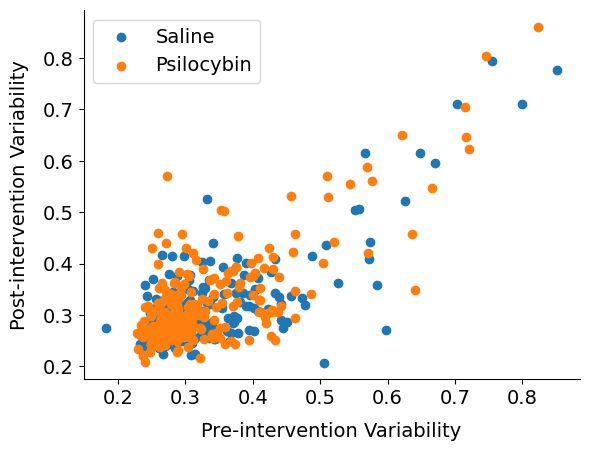

In [27]:
plt.scatter(QI_pre_saline,QI_post_saline,label='Saline')
plt.scatter(QI_pre_psilo,QI_post_psilo,label='Psilocybin')
plt.legend(fontsize=14)
plt.xlabel("Pre-intervention Variability",fontsize=14,labelpad=10)
plt.ylabel("Post-intervention Variability",fontsize=14,labelpad=10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.title("",pad=10)

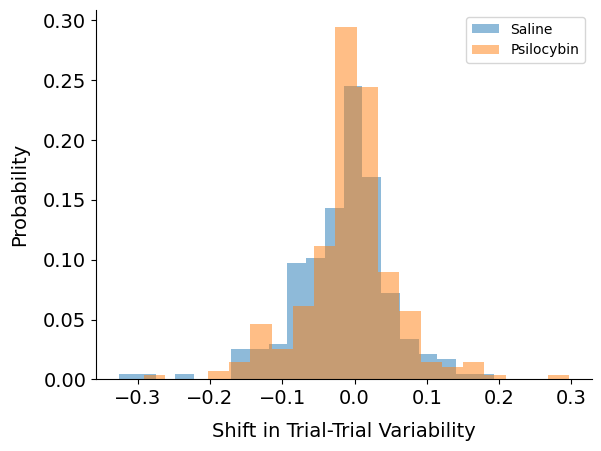

In [28]:

plt.hist(QI_shift_saline, weights=np.zeros_like(QI_shift_saline) + 1. / len(QI_shift_saline),bins=20,alpha=0.5,label='Saline')
plt.hist(QI_shift_psilo, weights=np.zeros_like(QI_shift_psilo) + 1. / len(QI_shift_psilo),bins=20,alpha=0.5,label='Psilocybin')
# plt.title("Shift in Trial-Trial Variability, Saline vs. Psilocybin")
plt.xlabel("Shift in Trial-Trial Variability",fontsize=14,labelpad=10)
plt.ylabel("Probability",fontsize=14,labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper right') 

In [60]:
print(np.median(QI_all_cells_saline_post))
print(np.median(QI_all_cells_psilo_post))

0.17756713955327375
0.16897842491289022


Text(0, 0.5, 'Probabiliy')

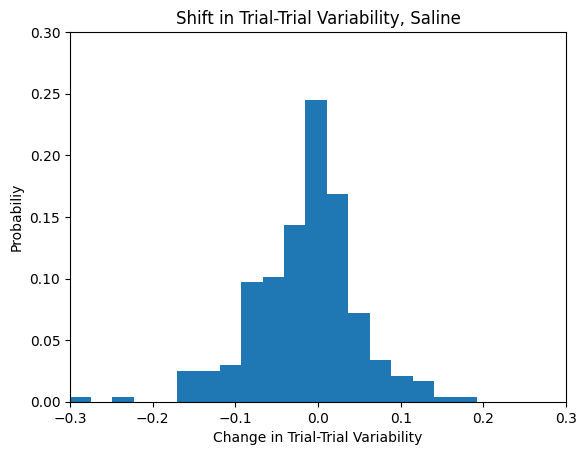

In [29]:
plt.hist(QI_shift_saline, weights=np.zeros_like(QI_shift_saline) + 1. / len(QI_shift_saline),bins=20)
plt.xlim(-0.3,0.3)
plt.ylim(0,0.30)
plt.title("Shift in Trial-Trial Variability, Saline")
plt.xlabel("Change in Trial-Trial Variability")
plt.ylabel("Probabiliy")

In [23]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(QI_shift_saline, QI_shift_psilo)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 30467.0
P-value: 0.12432348710981213


In [13]:
# Perform KS test between two samples
ks_statistic, p_value = ss.kstest(QI_shift_saline, QI_shift_psilo)

# Print test results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.10689170182841069
P-value: 0.0974182520803265


In [32]:
np.median(QI_shift_psilo)

-0.004817094877745509

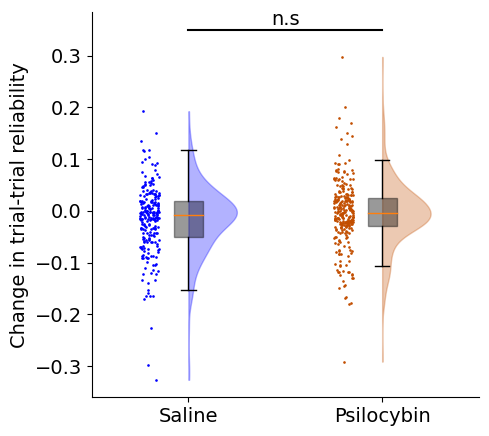

In [30]:
data_x = [QI_shift_saline, QI_shift_psilo]

fig, ax = plt.subplots(figsize=(5, 5))

# Create a list of colors for the boxplots based on the number of features you have
boxplots_colors = ['black', 'black']

# Boxplot data
bp = ax.boxplot(data_x, patch_artist=True,showfliers=False)

# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], boxplots_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Create a list of colors for the violin plots based on the number of features you have
violin_colors = ['b', '#c24e00']

# Violinplot data
vp = ax.violinplot(data_x, points=500, showmeans=False, showextrema=False, showmedians=False)

for idx, b in enumerate(vp['bodies']):
    # Get the center of the plot
    m = np.mean(b.get_paths()[0].vertices[:, 1])
    # Modify it so we only see the upper half of the violin plot
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], idx + 1, idx + 2)
    # Change to the desired color
    b.set_color(violin_colors[idx])

# Create a list of colors for the scatter plots based on the number of features you have
scatter_colors = ['b', '#c24e00']

# Scatterplot data
for idx, features in enumerate(data_x):
    # Add jitter effect so the features do not overlap on the x-axis
    x = np.full(len(features), idx + .8)
    idxs = np.arange(len(x))
    out = x.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
    x = out
    plt.scatter(x, features, s=.8, c=scatter_colors[idx])

plt.xticks(np.arange(1, 3, 1), ['Saline', 'Psilocybin'],fontsize=14)  # Set text labels.
# plt.ylim(bottom=min(min(relative_changes), min(relative_changes_2)), top=11)  # Limit y-axis to values below 10
plt.ylabel('Change in trial-trial reliability',fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(xmin=0.25, xmax=0.75, y=0.35, color='black', linestyle='-')
plt.text(1.5, 0.37, 'n.s', horizontalalignment='center', verticalalignment='center',fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()